<div class="alert alert-block alert-danger">
    
### Notes 

</div>

### Weighted Least Squares, Numerical python, $\dots$

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from scipy import stats

import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [3]:
plt.close('all')

np.random.seed(1234)

***

#### Heteroscedasticity

\begin{align}
\Sigma = 
\begin{pmatrix}
\sigma_{1}^2 & 0 & \cdots & 0 \\
0 & \sigma_{2}^2 & \cdots & 0 \\
\vdots  & \vdots  & \ddots & \vdots  \\
0 & 0 & \cdots & \sigma_{n}^2 
\end{pmatrix}
\end{align}

<br><br>

\begin{align}
\mathbf{W} = 
\begin{pmatrix}
1/\sigma_{1}^2 & 0 & \cdots & 0 \\
0 & 1/\sigma_{2}^2 & \cdots & 0 \\
\vdots  & \vdots  & \ddots & \vdots  \\
0 & 0 & \cdots & 1/\sigma_{n}^2 
\end{pmatrix}
\end{align}

***

$\hat{\beta} = (\mathbf{X}^\intercal \mathbf{W} \mathbf{X})^{-1} \mathbf{X}^\intercal \mathbf{W} \mathbf{Y}$

***

In [4]:
X = np.linspace(0, 100, 100)
weights = np.random.choice([3, 5, 20], size=100, p=[0.4, 0.5, 0.1])
error_stds = np.random.normal(loc=0, scale=10) * weights
Y = 2 * X + error_stds

In [5]:
lm_results =sm.OLS(Y, sm.add_constant(X)).fit()
lm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     258.7
Date:                Wed, 25 Mar 2020   Prob (F-statistic):           3.04e-29
Time:                        01:46:13   Log-Likelihood:                -502.61
No. Observations:                 100   AIC:                             1009.
Df Residuals:                      98   BIC:                             1014.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         42.1247      7.391      5.699      0.000      27.457      56.793
x1             2.0538      0.128     16.083      0.000       1.800       2.307
==============================================================================
Omnibus:                       64.032   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              189.394
Skew:                           2.482   Prob(JB):                     7.47e-42
Kurtosis:                       7.562   Cond. No.                         115.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
weights = 1/np.square(error_stds)

In [7]:
wm_results = sm.WLS(Y, sm.add_constant(X), weights).fit()
wm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.965
Model:                            WLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     2742.
Date:                Wed, 25 Mar 2020   Prob (F-statistic):           1.88e-73
Time:                        01:46:13   Log-Likelihood:                -398.18
No. Observations:                 100   AIC:                             800.4
Df Residuals:                      98   BIC:                             805.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.2843      2.178     12.989      0.000      23.963      32.605
x1             2.0235      0.039     52.360      0.000       1.947       2.100
==============================================================================
Omnibus:                        2.345   Durbin-Watson:                   1.694
Prob(Omnibus):                  0.310   Jarque-Bera (JB):                2.365
Skew:                           0.347   Prob(JB):                        0.306
Kurtosis:                       2.707   Cond. No.                         111.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
tvalue, pvalue, _, _ = sm.stats.diagnostic.het_breuschpagan(lm_results.resid, lm_results.model.exog)
print('OLS Breusch-Pagan tvalue: {}, pvalue: {}'.format(tvalue, pvalue))

OLS Breusch-Pagan tvalue: 0.07217009923772277, pvalue: 0.7882029325013413


In [9]:
tvalue, pvalue, _, _ = sm.stats.diagnostic.het_breuschpagan(wm_results.resid, wm_results.model.exog)
print('WLS Breusch-Pagan tvalue: {}, pvalue: {}'.format(tvalue, pvalue))

WLS Breusch-Pagan tvalue: 0.06412136865189266, pvalue: 0.8000966861300151


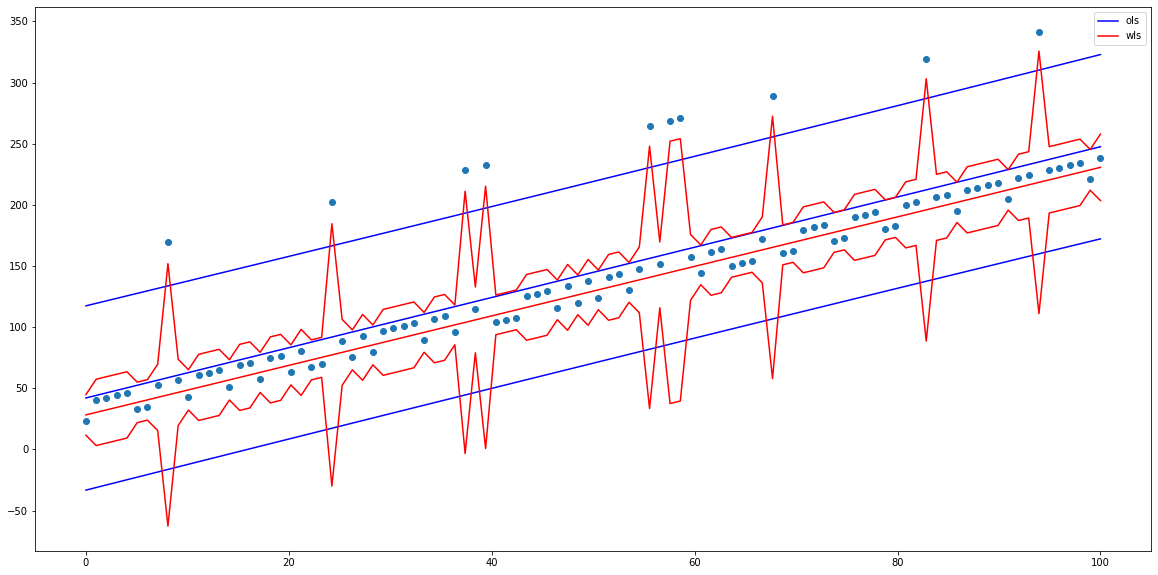

In [10]:
_, wm_iv_l, wm_iv_u = wls_prediction_std(wm_results)
_, lm_iv_l, lm_iv_u = wls_prediction_std(lm_results)

plt.figure(figsize=(20,10))
plt.scatter(X, Y)

plt.plot(X, lm_results.fittedvalues, color='b', label='ols')
plt.plot(X, lm_iv_l, color='b')
plt.plot(X, lm_iv_u, color='b')

plt.plot(X, wm_results.fittedvalues, color='r', label='wls')
plt.plot(X, wm_iv_l, color='r')
plt.plot(X, wm_iv_u, color='r')

plt.legend(loc=0);

***

##### Second approach

- $ \mid \text{ (OLS residuals)} \mid \sim\text{(OLS fitted values)}$. 

- $\hat{\sigma} = \text{new fitted values}$.

- weights $= \frac{1}{\hat{\sigma}^2}$.

In [11]:
lm_resids, lm_fittedvalues = np.abs(lm_results.resid), lm_results.fittedvalues
lm_residsVSfits = sm.OLS(lm_resids, sm.add_constant(lm_fittedvalues)).fit()

std_err_estimates = lm_residsVSfits.fittedvalues
new_weights = 1./(std_err_estimates**2)

wm_results_again = sm.WLS(Y, sm.add_constant(X), new_weights).fit()
wm_results_again.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.729
Model:                            WLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     263.4
Date:                Wed, 25 Mar 2020   Prob (F-statistic):           1.58e-29
Time:                        01:46:14   Log-Likelihood:                -502.44
No. Observations:                 100   AIC:                             1009.
Df Residuals:                      98   BIC:                             1014.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.4939      6.876      6.034      0.000      27.848      55.139
x1             2.0667      0.127     16.231      0.000       1.814       2.319
==============================================================================
Omnibus:                       65.133   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              199.035
Skew:                           2.507   Prob(JB):                     6.03e-44
Kurtosis:                       7.757   Cond. No.                         101.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

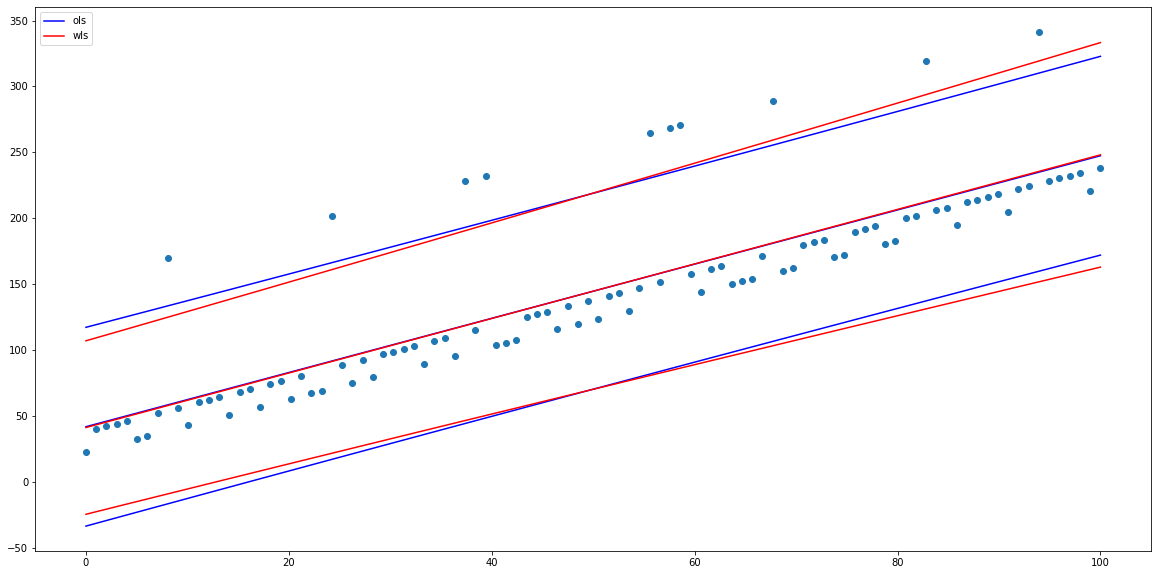

In [12]:
_, wm_again_iv_l, wm_again_iv_u = wls_prediction_std(wm_results_again)
_, lm_iv_l, lm_iv_u = wls_prediction_std(lm_results)

plt.figure(figsize=(20,10))
plt.scatter(X, Y)

plt.plot(X, lm_results.fittedvalues, color='b', label='ols')
plt.plot(X, lm_iv_l, color='b')
plt.plot(X, lm_iv_u, color='b')

plt.plot(X, wm_results_again.fittedvalues, color='r', label='wls')
plt.plot(X, wm_again_iv_l, color='r')
plt.plot(X, wm_again_iv_u, color='r')

plt.legend(loc=0);